In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from animate_play import animate_play
from common import COLOR_MAPPING


### This file will be used to explore tracking_week_1.csv data. All subsequent weeks are the same columns so to keep the size of the investigation reasonable I'll only look at week 1.

In [67]:
df = pd.read_csv('./data/tracking_week_1.csv')
print(df.shape)

(7104700, 18)


In [68]:
print(df.describe())

             gameId        playId         nflId       frameId  jerseyNumber  \
count  7.104700e+06  7.104700e+06  6.795800e+06  7.104700e+06  6.795800e+06   
mean   2.022091e+09  2.024279e+03  4.718625e+04  8.693164e+01  4.808540e+01   
std    7.693544e+01  1.227634e+03  5.050182e+03  5.901554e+01  3.081648e+01   
min    2.022091e+09  5.500000e+01  2.551100e+04  1.000000e+00  1.000000e+00   
25%    2.022091e+09  9.550000e+02  4.338400e+04  4.000000e+01  2.100000e+01   
50%    2.022091e+09  1.995000e+03  4.621400e+04  8.100000e+01  5.100000e+01   
75%    2.022091e+09  3.043000e+03  5.249800e+04  1.260000e+02  7.500000e+01   
max    2.022091e+09  5.120000e+03  5.517300e+04  6.970000e+02  9.900000e+01   

                  x             y             s             a           dis  \
count  7.104700e+06  7.104700e+06  7.104700e+06  7.104700e+06  7.104700e+06   
mean   6.087936e+01  2.682726e+01  1.359180e+00  9.440965e-01  1.389657e-01   
std    2.456882e+01  7.696377e+00  1.889584e+00  1.

In [69]:
print(df.columns)
df[['gameId', 'playId', 'displayName', 'frameId', 'x', 'y', 'event']].head().to_clipboard()


Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a',
       'dis', 'o', 'dir', 'event'],
      dtype='object')


gameId      playId
2022091101  4174       17
            4128       18
2022091102  4231       18
2022091100  4068       23
2022091109  4596       26
                     ... 
2022091200  3723      403
2022091112  2072      425
2022091104  3122      466
            3204      581
2022091103  4993      697
Name: frameId, Length: 1952, dtype: int64

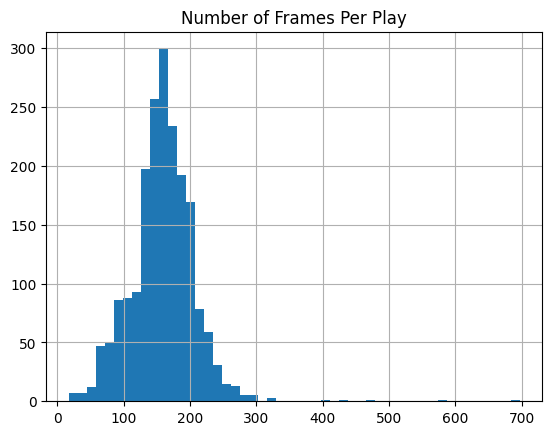

In [70]:
#Show histogram of the number of frameId per playId
df.groupby(['gameId', 'playId'])['frameId'].max().hist(bins=50)
plt.title("Number of Frames Per Play")
df.groupby(['gameId', 'playId'])['frameId'].max().sort_values()

<Axes: >

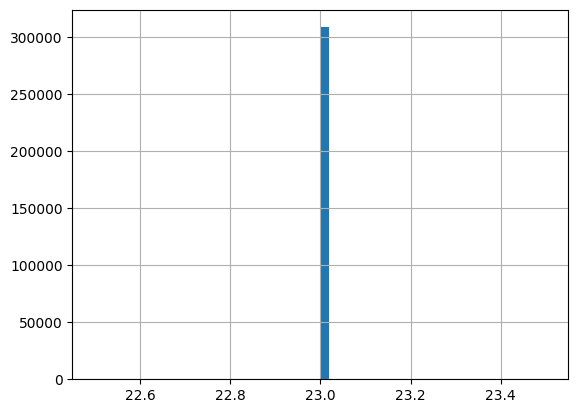

In [71]:
# How many rows per frameId per playId
df.groupby(['gameId', 'playId', 'frameId'])['displayName'].count().hist(bins=50)

That's what I'd expect (11 players per side plus the football)

In the end one of the best ways to visualize this data is to watch a play in action. I found a thought out code snippet that will animate a play on kaggle so I'm using that for this piece:

In [72]:
play_df = pd.read_csv('./data/plays.csv')
players = pd.read_csv('./data/players.csv')
animate_play(df, play_df, players, gameId=2022091103, playId=3849)


In [73]:
# Let's get a view of the event values
df['event'].unique()

array(['huddle_break_offense', nan, 'line_set', 'man_in_motion',
       'ball_snap', 'handoff', 'first_contact', 'tackle', 'pass_forward',
       'pass_arrived', 'pass_outcome_caught', 'touchdown', 'dropped_pass',
       'pass_outcome_incomplete', 'play_action', 'out_of_bounds', 'run',
       'qb_sack', 'pass_tipped', 'fumble', 'fumble_offense_recovered',
       'shift', 'fumble_defense_recovered', 'touchback', 'qb_strip_sack',
       'qb_kneel', 'timeout_away', 'snap_direct',
       'pass_outcome_interception', 'qb_slide', 'play_submit',
       'pass_outcome_touchdown', 'lateral', 'qb_spike', 'pass_shovel',
       'run_pass_option', 'huddle_start_offense'], dtype=object)

We could potentially use unsupervised learning to see if we can identify how many different formations an offense uses. Let's look at some possible data we'd need.

In [74]:
# First we really only need to look at the formation at the time the ball is snapped
print(df.shape)
formation_df = df[df['event'] == 'ball_snap']
print(formation_df.shape) # should essentailly be 23 rows per playId
print(formation_df.head())

(7104700, 18)
(44804, 18)
         gameId  playId    nflId     displayName  frameId frameType  \
113  2022091200      64  35459.0  Kareem Jackson      114      SNAP   
276  2022091200      64  39987.0      Geno Smith      114      SNAP   
439  2022091200      64  41310.0    Gabe Jackson      114      SNAP   
602  2022091200      64  42393.0    Ronald Darby      114      SNAP   
765  2022091200      64  42403.0   Randy Gregory      114      SNAP   

                      time  jerseyNumber club playDirection      x      y  \
113  2022-09-13 00:16:14.8          22.0  DEN         right  50.29  29.43   
276  2022-09-13 00:16:14.8           7.0  SEA         right  37.94  23.86   
439  2022-09-13 00:16:14.8          66.0  SEA         right  38.52  22.21   
602  2022-09-13 00:16:14.8          23.0  DEN         right  47.39  13.41   
765  2022-09-13 00:16:14.8           5.0  DEN         right  40.50  17.63   

        s     a   dis       o     dir      event  
113  1.13  1.62  0.11  240.06  13

In [75]:
# Let's look at the distance of key players from the football at the time of the snap
# For each playId and frameId, get the football's x and y position and merge it back to all players
position_df = formation_df.merge(players[['position', 'nflId']], on='nflId', how='left')
football_positions = formation_df[formation_df['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
football_positions = football_positions.rename(columns={'x': 'football_x', 'y': 'football_y'})

# annotate the dataframe with whether the team is the offense or defense which can be pulled from the play_df possesionTeam column
football_df = position_df.merge(play_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'], how='left')

football_df = football_df.merge(football_positions, on=['gameId', 'playId', 'frameId'], how='left')
football_df = football_df[football_df['displayName'] != 'football']
football_df['distance_from_football'] = np.sqrt((football_df['x'] - football_df['football_x'])**2 + (football_df['y'] - football_df['football_y'])**2)
football_df.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,a,dis,o,dir,event,position,possessionTeam,football_x,football_y,distance_from_football
0,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,22.0,DEN,right,...,1.62,0.11,240.06,133.16,ball_snap,SS,SEA,38.529999,24.110001,12.907363
1,2022091200,64,39987.0,Geno Smith,114,SNAP,2022-09-13 00:16:14.8,7.0,SEA,right,...,1.79,0.08,79.67,218.22,ball_snap,QB,SEA,38.529999,24.110001,0.640780
2,2022091200,64,41310.0,Gabe Jackson,114,SNAP,2022-09-13 00:16:14.8,66.0,SEA,right,...,1.33,0.09,134.48,197.49,ball_snap,G,SEA,38.529999,24.110001,1.900027
3,2022091200,64,42393.0,Ronald Darby,114,SNAP,2022-09-13 00:16:14.8,23.0,DEN,right,...,0.58,0.02,284.20,103.97,ball_snap,CB,SEA,38.529999,24.110001,13.892071
4,2022091200,64,42403.0,Randy Gregory,114,SNAP,2022-09-13 00:16:14.8,5.0,DEN,right,...,0.71,0.07,271.43,246.73,ball_snap,OLB,SEA,38.529999,24.110001,6.772836


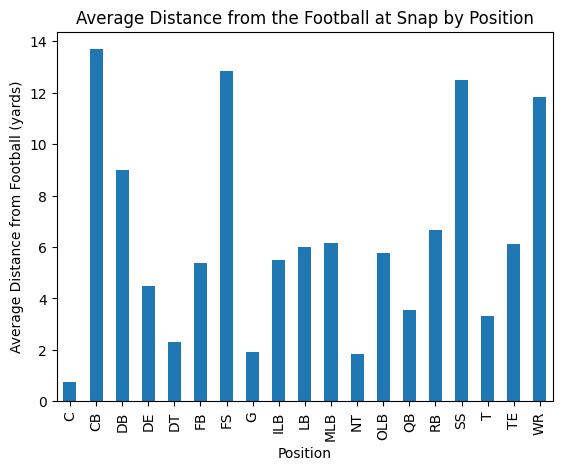

Text(0, 0.5, 'Position')

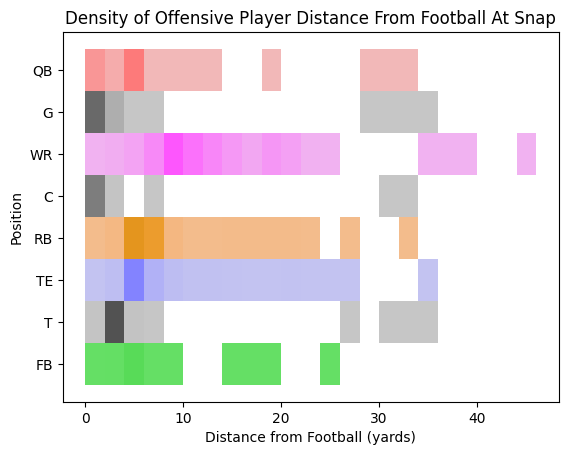

In [76]:
# show a histogram of the distance from the ball for each position
football_df.groupby('position')['distance_from_football'].mean().plot(kind='bar')
# set max x axis to 500
plt.title('Average Distance from the Football at Snap by Position')
plt.xlabel('Position')
plt.ylabel('Average Distance from Football (yards)')
plt.show()


# Offense Only
sns.histplot(
    football_df[(football_df['possessionTeam'] == football_df['club'])], x="distance_from_football", y="position", hue="position", legend=False, binwidth=2, palette=COLOR_MAPPING
)
plt.title("Density of Offensive Player Distance From Football At Snap")
plt.xlabel("Distance from Football (yards)")
plt.ylabel("Position")

In [77]:
# Let's look at the distance of key players from the center at the time of the snap
# For each playId and frameId, get the center's x and y position and merge it back to all players
position_df = formation_df.merge(players[['position', 'nflId']], on='nflId', how='left')
center_positions = position_df[position_df['position'] == 'C'][['gameId', 'playId', 'frameId', 'x', 'y']]
center_positions = center_positions.rename(columns={'x': 'center_x', 'y': 'center_y'})

# annotate the dataframe with whether the team is the offense or defense which can be pulled from the play_df possesionTeam column
formation_df = position_df.merge(play_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'], how='left')

distance_df = formation_df.merge(center_positions, on=['gameId', 'playId', 'frameId'], how='left')
distance_df = distance_df[distance_df['displayName'] != 'football']
distance_df['distance_from_c'] = np.sqrt((distance_df['x'] - distance_df['center_x'])**2 + (distance_df['y'] - distance_df['center_y'])**2)
distance_df.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,a,dis,o,dir,event,position,possessionTeam,center_x,center_y,distance_from_c
0,2022091200,64,35459.0,Kareem Jackson,114,SNAP,2022-09-13 00:16:14.8,22.0,DEN,right,...,1.62,0.11,240.06,133.16,ball_snap,SS,SEA,39.17,23.66,12.527861
1,2022091200,64,39987.0,Geno Smith,114,SNAP,2022-09-13 00:16:14.8,7.0,SEA,right,...,1.79,0.08,79.67,218.22,ball_snap,QB,SEA,39.17,23.66,1.246154
2,2022091200,64,41310.0,Gabe Jackson,114,SNAP,2022-09-13 00:16:14.8,66.0,SEA,right,...,1.33,0.09,134.48,197.49,ball_snap,G,SEA,39.17,23.66,1.589025
3,2022091200,64,42393.0,Ronald Darby,114,SNAP,2022-09-13 00:16:14.8,23.0,DEN,right,...,0.58,0.02,284.20,103.97,ball_snap,CB,SEA,39.17,23.66,13.138908
4,2022091200,64,42403.0,Randy Gregory,114,SNAP,2022-09-13 00:16:14.8,5.0,DEN,right,...,0.71,0.07,271.43,246.73,ball_snap,OLB,SEA,39.17,23.66,6.174933


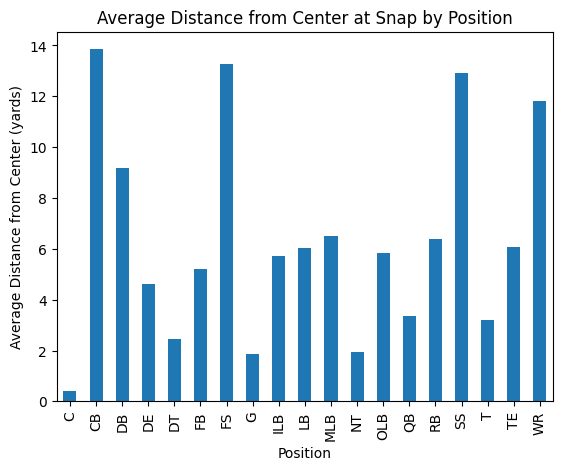

Text(0, 0.5, 'Position')

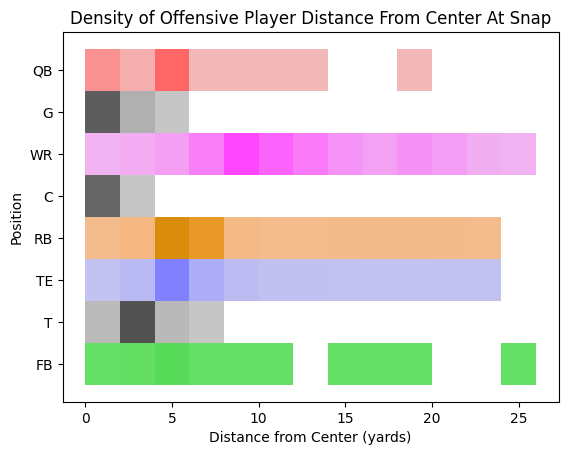

In [78]:

# show a histogram of the distance from the ball for each position
distance_df.groupby('position')['distance_from_c'].mean().plot(kind='bar')
# set max x axis to 500
plt.title('Average Distance from Center at Snap by Position')
plt.xlabel('Position')
plt.ylabel('Average Distance from Center (yards)')
plt.show()


# Offense Only
sns.histplot(
    distance_df[(distance_df['possessionTeam'] == distance_df['club'])], x="distance_from_c", y="position", hue="position", legend=False, binwidth=2, palette=COLOR_MAPPING
)
plt.title("Density of Offensive Player Distance From Center At Snap")
plt.xlabel("Distance from Center (yards)")
plt.ylabel("Position")


It's strange to see positions like guard, center or tackle so far from the ball. Even 30 yards for a WR or running back seems odd. I want to look at some of those because maybe I am missing something about the data.

In [79]:
football_df[(football_df['position'] == 'QB') & (football_df['distance_from_football'] > 30)]
# df[(df['gameId'] == 2022091108) & (df['playId'] == 3947) & (df['event'] == 'ball_snap')]

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,a,dis,o,dir,event,position,possessionTeam,football_x,football_y,distance_from_football
7613,2022091108,3947,38538.0,Ryan Tannehill,50,SNAP,2022-09-11 23:25:14.7,17.0,TEN,left,...,0.20,0.01,257.76,216.64,ball_snap,QB,TEN,38.830002,-0.85,30.598778
42002,2022091100,4068,42344.0,Jameis Winston,11,SNAP,2022-09-11 20:02:01.5,2.0,NO,right,...,1.27,0.01,34.36,300.69,ball_snap,QB,NO,53.669998,0.08,33.223827


In [80]:
animate_play(df, play_df, players, gameId=2022091100, playId=4068)

It's interesting that this is a spiked ball play (quarterback intentionally throws the ball at the ground to stop the clock resulting in an incomplete pass) and the football is outside of the normal bounds of play (38.830002	-0.85). This position might be expected for passes that go out of bounds but we will only be looking at the time the ball is snapped and the ball should be firmly on the field for that to happen.

In [81]:
# remove frames where the football x or y is outside the field boundaries
# clean_position_df = position_df[(position_df['football_x'] > 0) & (position_df['center_x'] < 120) & (position_df['football_y'] > 0) & (position_df['football_y'] < 53.3)]

/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_2526/3108144686.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



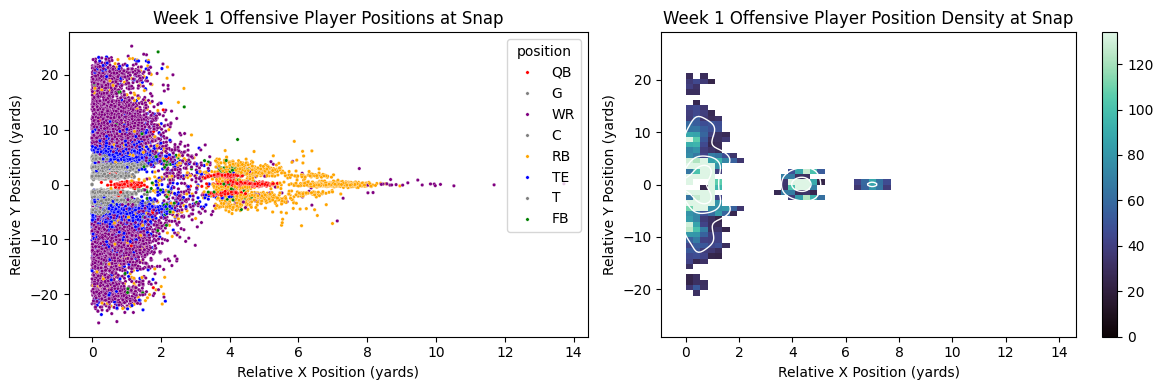

In [82]:
# Adjust every player's position to be relative to the line of scrimmage
# join with plays_df to get line of scrimmage
off_df = distance_df[(distance_df['possessionTeam'] == distance_df['club'])]
off_df = off_df[~(distance_df['displayName']=='football')]
off_df['distance_from_C'] = np.sqrt((off_df['x'] - off_df['center_x'])**2 + (off_df['y'] - off_df['center_y'])**2)
off_df['rel_x_c'] = np.abs(off_df['center_x'] - off_df['x'])
off_df['rel_y_c'] = off_df['center_y'] - off_df['y']

# Display a heatmap of every player's position on the field
f, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[3, 3]))
sns.scatterplot(off_df, x='rel_x_c', y='rel_y_c', s=6, hue="position", ax=axs[0], palette=COLOR_MAPPING)
sns.histplot(x=off_df['rel_x_c'], y=off_df['rel_y_c'], bins=50, pthresh=.1, cmap="mako", pmax=.5, ax=axs[1], cbar=True)
sns.kdeplot(x=off_df['rel_x_c'], y=off_df['rel_y_c'], levels=5, color='w', linewidths=1, ax=axs[1])
axs[0].set_title("Week 1 Offensive Player Positions at Snap")
axs[1].set_title("Week 1 Offensive Player Position Density at Snap")
axs[0].set_xlabel("Relative X Position (yards)")
axs[0].set_ylabel("Relative Y Position (yards)")
axs[1].set_xlabel("Relative X Position (yards)")
axs[1].set_ylabel("Relative Y Position (yards)")
f.tight_layout()

In [83]:
off_df[off_df['rel_x_c'] > 10]

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,dir,event,position,possessionTeam,center_x,center_y,distance_from_c,distance_from_C,rel_x_c,rel_y_c
14220,2022091111,3683,44819.0,Mike Williams,50,SNAP,2022-09-11 23:19:08.9,81.0,LAC,right,...,64.63,ball_snap,WR,LAC,87.31,26.84,10.522737,10.522737,10.52,-0.24
25370,2022091106,1709,42437.0,Ty Montgomery,48,SNAP,2022-09-11 18:19:47.7,14.0,NE,left,...,14.39,ball_snap,WR,NE,85.34,27.28,10.130020,10.130020,10.13,0.02
34655,2022091104,2385,53541.0,Amon-Ra St. Brown,50,SNAP,2022-09-11 18:40:29.5,14.0,DET,right,...,113.93,ball_snap,WR,DET,34.35,26.49,13.720820,13.720820,13.72,0.15
36149,2022091104,4513,53439.0,DeVonta Smith,68,SNAP,2022-09-11 20:19:19.5,6.0,PHI,right,...,58.94,ball_snap,WR,PHI,65.89,29.98,11.690154,11.690154,11.69,-0.06


In [84]:

final_df = distance_df.merge(players[['position', 'nflId']], on='nflId', how='left')
final_df = final_df[(final_df['possessionTeam'] == final_df['club']) | (final_df['displayName'] == 'football')] # only keep offensive players
final_df.drop(columns=['gameId', 'nflId', 'displayName', 'frameId', 'frameType', 'time', 'jerseyNumber', 'club', 'possessionTeam', 's', 'a', 'dis', 'o', 'dir', 'event'], inplace=True) # drop unneeded columns
print(final_df.head())
print(final_df.shape)

    playId playDirection      x      y position_x  center_x  center_y  \
1       64         right  37.94  23.86         QB     39.17     23.66   
2       64         right  38.52  22.21          G     39.17     23.66   
5       64         right  39.41  14.39         WR     39.17     23.66   
9       64         right  39.17  23.66          C     39.17     23.66   
12      64         right  32.15  23.82         RB     39.17     23.66   

    distance_from_c position_y  
1          1.246154         QB  
2          1.589025          G  
5          9.273106         WR  
9          0.000000          C  
12         7.021823         RB  
(25608, 9)


In [85]:
# Table show number of plays with more than 1 center, more than 1 quarterback or 3 tackles or 3 guards
center_only_df = position_df[position_df['position'] == 'C']
# print("Number of plays with more than 1 center: ", center_only_df[center_only_df.groupby(['gameId', 'playId'])['displayName'].transform('count') > 1])
s = center_only_df.groupby(['gameId', 'playId']).size()
print("Number of plays with more than 1 center: ", s[s > 1].count())
qb_df = position_df[position_df['position'] == 'QB']
qb = qb_df.groupby(['gameId', 'playId']).size()
print("Number of plays with more than 1 quarterback: ", qb[qb > 1].count())

g_df = position_df[position_df['position'] == 'G']
g = g_df.groupby(['gameId', 'playId']).size()
print("Number of plays with more than 3 guards: ", g[g>2].count())

Number of plays with more than 1 center:  380
Number of plays with more than 1 quarterback:  15
Number of plays with more than 3 guards:  145
